# Find the Vehicles - Model Training

An AI model will be developed using a deep learning framework that predicts the type of vehicle present in an image as well as localizes the vehicle with a rectangular bounding box

## Steps to Be Followed:
1.   Import the necessary libraries
2.   Visualize the images and labels data
3.   Prepare the Data
4.   Clone the YOLOV5 repository
5.   Train the model
6.   Show validation data predictions
7.   Visualize inferenced images


### Step 1: Import the necessary libraries

In [1]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
from IPython.display import Image

### Step 2: Visualize the images and labels data for training

In [3]:
labels_path = "/content/drive/MyDrive/Colab Notebooks/capstone1/labels.csv"

# Load the labels CSV
labels_df = pd.read_csv(labels_path, delimiter=',', header=None)
labels_df.columns = ['image_id', 'class_name', 'x1', 'y1', 'x2', 'y2']
labels_df.head(10)

,image_id,class_name,x1,y1,x2,y2
0,0,pickup_truck,213,34,255,50
1,0,car,194,78,273,122
2,0,car,155,27,183,35
3,0,articulated_truck,43,25,109,55
4,0,car,106,32,124,45
5,1,bus,205,155,568,314
6,1,bus,285,123,477,168
7,1,car,544,162,617,193
8,1,car,329,152,371,163
9,1,car,447,161,497,183


In [4]:
# Assign column names
labels_df["class_name"].unique()

array(['pickup_truck', 'car', 'articulated_truck', 'bus',
       'motorized_vehicle', 'work_van', 'single_unit_truck', 'pedestrian',
       'bicycle', 'non-motorized_vehicle', 'motorcycle'], dtype=object)

In [31]:
# Count of values fo each category
labels_df["class_name"].value_counts()

class_name
car                      233497
pickup_truck              44283
motorized_vehicle         25845
bus                       10598
articulated_truck          9301
work_van                   8709
pedestrian                 7128
single_unit_truck          5741
non-motorized_vehicle      2350
bicycle                    2260
motorcycle                 1837
Name: count, dtype: int64

In [32]:
images_dir = '/content/drive/MyDrive/Colab Notebooks/capstone1/Images'

# Function to draw bounding boxes on an image
def draw_bounding_boxes(image_path, bboxes):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for bbox in bboxes:
        x1, y1, x2, y2, class_name = bbox
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_thickness = 1
        text_size, _ = cv2.getTextSize(class_name, font, font_scale,
                                       font_thickness)
        text_w, text_h = text_size

        # draw label bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Draw a dark rectangle for label text background
        cv2.rectangle(image, (x1, y1 - text_h - 2), (x1 + text_w, y1),
                      (0, 0, 0), -1)

        # Put label text on top of the dark rectangle
        cv2.putText(image, class_name, (x1, y1 - 2), font, font_scale,
                    (255, 255, 255), font_thickness)
    return image

# Get the first 6 images to display
sample_images = labels_df['image_id'].unique()[:6]

# Plot images with bounding boxes
plt.figure(figsize=(15, 15))
for i, img_id in enumerate(sample_images):
    img_path = os.path.join(images_dir, f'{str(img_id).zfill(8)}.jpg')
    bboxes = labels_df[labels_df['image_id'] == img_id][['x1', 'y1', 'x2', 'y2',
                                                         'class_name']].values
    image_with_bboxes = draw_bounding_boxes(img_path, bboxes)
    plt.subplot(3, 2, i + 1)
    plt.imshow(image_with_bboxes)
    plt.title(f'Image ID: {img_id}')
    plt.axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [33]:
# checking the labels on image with ID 5, since not legible on image above
labels_df[labels_df['image_id'] == 5]

,image_id,class_name,x1,y1,x2,y2
15,5,car,561,85,605,129
16,5,articulated_truck,132,3,712,254


### Step 3: Prepare the Data

#### Step 3.1: Transform the labels to YOLOv5 format
Data labels are on a different format from the necessary one for YOLOv5 model. Currently as (image_id, class, x1, x2, y1, y2) in a csv file. Necessary format for YOLOv5 is (class_id, x_center, y_center, width, height) and the name of the fule being image_id.txt. Meaning there is one txt file for each image.

In [ ]:

# Define the paths
output_labels_dir = os.path.join(images_dir, 'YOLO_labels')

# Ensure the output directory exists
os.makedirs(output_labels_dir, exist_ok=True)

# Adjust the filename format to include leading zeros for image_id
labels_df['image_id'] = labels_df['image_id'].apply(lambda x: f'{x:08}')

# Create a mapping from class names to class IDs
class_mapping = {name: idx for idx, name in enumerate(labels_df['class_name'].unique())}

# Function to convert bounding box to YOLO format
def convert_bbox_to_yolo(image_width, image_height, x1, y1, x2, y2):
    x_center = (x1 + x2) / 2.0 / image_width
    y_center = (y1 + y2) / 2.0 / image_height
    width = (x2 - x1) / image_width
    height = (y2 - y1) / image_height
    return x_center, y_center, width, height

# Process each image
for img_id in labels_df['image_id'].unique():
    img_path = os.path.join(images_dir, f'{img_id}.jpg')
    image = cv2.imread(img_path)
    image_height, image_width = image.shape[:2]

    # Get all bounding boxes for this image
    bboxes = labels_df[labels_df['image_id'] == img_id][['x1', 'y1', 'x2', 'y2',
                                                         'class_name']].values

    # Convert each bounding box to YOLO format
    yolo_labels = []
    for bbox in bboxes:
        x1, y1, x2, y2, class_name = bbox
        class_id = class_mapping[class_name]
        x_center, y_center, width, height = convert_bbox_to_yolo(image_width, image_height, x1, y1, x2, y2)
        yolo_labels.append(f"{class_id} {x_center} {y_center} {width} {height}")

    # Save the YOLO labels to a file
    output_label_path = os.path.join(output_labels_dir, f'{img_id}.txt')
    with open(output_label_path, 'w') as f:
        f.write('\n'.join(yolo_labels))


In [ ]:
img_path

In [ ]:
np.set_printoptions(threshold=np.inf)
labels_df.sort_values(by="image_id", ascending=False)['image_id'].unique()

#### Step 3.2: Create directory structure and move images and labels
- Split data into training and validation data sets  
- Move data into required directory structure for YOLOv5:

```
    train/
        images/
        labels/
    val/
        images/
        labels/
```



In [24]:
# Create train and val directories
base_dir = '/content/drive/MyDrive/Colab Notebooks/capstone1'
src_images_dir = os.path.join(base_dir, 'Images')
src_labels_dir = os.path.join(base_dir, 'YOLO_labels')
train_images_dir = os.path.join(base_dir, 'images/train')
val_images_dir = os.path.join(base_dir, 'images/val')
train_labels_dir = os.path.join(base_dir, 'labels/train')
val_labels_dir = os.path.join(base_dir, 'labels/val')

os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

# Get list of image files
image_files = [f for f in os.listdir(src_images_dir) if f.endswith('.jpg')]

# Shuffle and split into train and val sets (80-20 split)
random.shuffle(image_files)
split_idx = int(0.8 * len(image_files))
train_files = image_files[:split_idx]
val_files = image_files[split_idx:]

# Function to move files (copy)
def move_files(file_list, src_images_dir, src_labels_dir, dst_images_dir, dst_labels_dir):
    for file_name in file_list:
        base_name = os.path.splitext(file_name)[0]
        img_src = os.path.join(src_images_dir, file_name)
        lbl_src = os.path.join(src_labels_dir, f'{base_name}.txt')
        img_dst = os.path.join(dst_images_dir, file_name)
        lbl_dst = os.path.join(dst_labels_dir, f'{base_name}.txt')
        shutil.copy(img_src, img_dst)
        shutil.copy(lbl_src, lbl_dst)

# Move train and val files
move_files(train_files, src_images_dir, src_labels_dir, train_images_dir, train_labels_dir)
move_files(val_files, src_images_dir, src_labels_dir, val_images_dir, val_labels_dir)


In [40]:
 def move_txt_files(src_txt_dir, src_jpg_dir, dst_dir):
     """
     Moves txt files from src_txt_dir to dst_dir if there is a jpg file with the same name in src_jpg_dir.

     Args:
         src_txt_dir (str): Source directory for txt files.
         src_jpg_dir (str): Source directory for jpg files.
         dst_dir (str): Destination directory for txt files.
     """

     # Get lists of txt and jpg files
     txt_files = os.listdir(src_txt_dir)
     jpg_files = os.listdir(src_jpg_dir)

     # Create a set of jpg filenames without extensions
     jpg_filenames = {os.path.splitext(filename)[0] for filename in jpg_files}

     # Iterate through txt files
     for txt_file in txt_files:
         # Get the filename without extension
         txt_filename = os.path.splitext(txt_file)[0]

         # Check if there is a jpg file with the same name
         if txt_filename in jpg_filenames:
             # Construct source and destination paths
             src_path = os.path.join(src_txt_dir, txt_file)
             dst_path = os.path.join(dst_dir, txt_file)

             # Move the file
             shutil.move(src_path, dst_path)

             print(f"Moved {txt_file} to {dst_dir}")

     print("All txt files moved successfully.")



In [38]:
move_txt_files("/content/drive/MyDrive/Colab Notebooks/capstone1/YOLO_labels",
               "/content/drive/MyDrive/Colab Notebooks/capstone1/data/train/images",
               "/content/drive/MyDrive/Colab Notebooks/capstone1/data/train/labels")

Moved 00004650.txt to /content/drive/MyDrive/Colab Notebooks/capstone1/data/train/labels
Moved 00004651.txt to /content/drive/MyDrive/Colab Notebooks/capstone1/data/train/labels
Moved 00004652.txt to /content/drive/MyDrive/Colab Notebooks/capstone1/data/train/labels
Moved 00004653.txt to /content/drive/MyDrive/Colab Notebooks/capstone1/data/train/labels
Moved 00004654.txt to /content/drive/MyDrive/Colab Notebooks/capstone1/data/train/labels
Moved 00004656.txt to /content/drive/MyDrive/Colab Notebooks/capstone1/data/train/labels
Moved 00004657.txt to /content/drive/MyDrive/Colab Notebooks/capstone1/data/train/labels
Moved 00004658.txt to /content/drive/MyDrive/Colab Notebooks/capstone1/data/train/labels
Moved 00004659.txt to /content/drive/MyDrive/Colab Notebooks/capstone1/data/train/labels
Moved 00004660.txt to /content/drive/MyDrive/Colab Notebooks/capstone1/data/train/labels
Moved 00004662.txt to /content/drive/MyDrive/Colab Notebooks/capstone1/data/train/labels
Moved 00004663.txt to

In [ ]:
move_txt_files("G:\Meu Drive\Colab Notebooks\capstone1\YOLO_labels",
               "G:\Meu Drive\Colab Notebooks\capstone1\data\val\images",
               "G:\Meu Drive\Colab Notebooks\capstone1\data\val\labels")

#### Step 3.3: Create custom_dataset.yaml
A YAML file is created to specify the dataset configuration for YOLOv5 training.

In [25]:
# Adjust files directories variables
base_dir = '/content/drive/MyDrive/Colab Notebooks/capstone1/'
train_images_dir = os.path.join(base_dir, 'data/train/images')
val_images_dir = os.path.join(base_dir, 'data/val/images')
train_labels_dir = os.path.join(base_dir, 'data/train/labels')
val_labels_dir = os.path.join(base_dir, 'data/val/labels')

# Create custom_dataset.yaml
dataset_yaml = f"""
train: {train_images_dir}
val: {val_images_dir}

# Number of classes
nc: 11

# Class names
names: [
  'pickup_truck', 'car', 'articulated_truck', 'bus',
  'motorized_vehicle', 'work_van', 'single_unit_truck', 'pedestrian',
  'bicycle', 'non-motorized_vehicle', 'motorcycle'
]
"""

yaml_path = os.path.join(base_dir, 'custom_dataset.yaml')
with open(yaml_path, 'w') as f:
    f.write(dataset_yaml)

print("Dataset preparation complete.")
print(f"Custom dataset YAML path: {yaml_path}")

Dataset preparation complete.
Custom dataset YAML path: /content/drive/MyDrive/Colab Notebooks/capstone1/custom_dataset.yaml


### Step 4: Clone the YOLOV5 repository

In [42]:
# Run bash commands (Command Line Interface)
%%bash

# Navigate into project's directory
cd '/content/drive/MyDrive/Colab Notebooks/capstone1'

# Clone YOLOv5 repository
git clone https://github.com/ultralytics/yolov5.git

# Navigate into YOLOv5 directory
cd yolov5

# Install required dependencies
pip install -r requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.


### Step 5: Train the model

In [7]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/capstone1'
yaml_path = os.path.join(base_dir, 'custom_dataset.yaml')

In [5]:
# Run bash commands (Command Line Interface)
%%bash

# Train YOLOv5
cd "/content/drive/MyDrive/Colab Notebooks/capstone1"  && \
# python train.py --img 640 --batch 16 --epochs 5 --data {yaml_path} --weights yolov5s.pt --project '/content/drive/MyDrive/Colab Notebooks/capstone1/yolov5/output'
# python yolov5/train.py --img 416 --batch 8 --epochs 5 --data "/content/drive/MyDrive/Colab Notebooks/capstone1/custom_dataset.yaml" --weights yolov5s.pt --project '/content/drive/MyDrive/Colab Notebooks/capstone1/yolov5/output'

python yolov5/train.py \
    --img 416 \
    --batch 8 \
    --epochs 5 \
    --data "/content/drive/MyDrive/Colab Notebooks/capstone1/custom_dataset.yaml" \
    --weights "/content/drive/MyDrive/Colab Notebooks/capstone1/yolov5/output/exp/weights/best.pt" \
    --project "/content/drive/MyDrive/Colab Notebooks/capstone1/yolov5/output"


2024-07-16 17:22:12.622893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 17:22:12.622966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 17:22:12.624735: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=/content/drive/MyDrive/Colab Notebooks/capstone1/custom_dataset.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=8, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=None, i

In [17]:
!nvidia-smi

Tue Jul 16 06:46:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

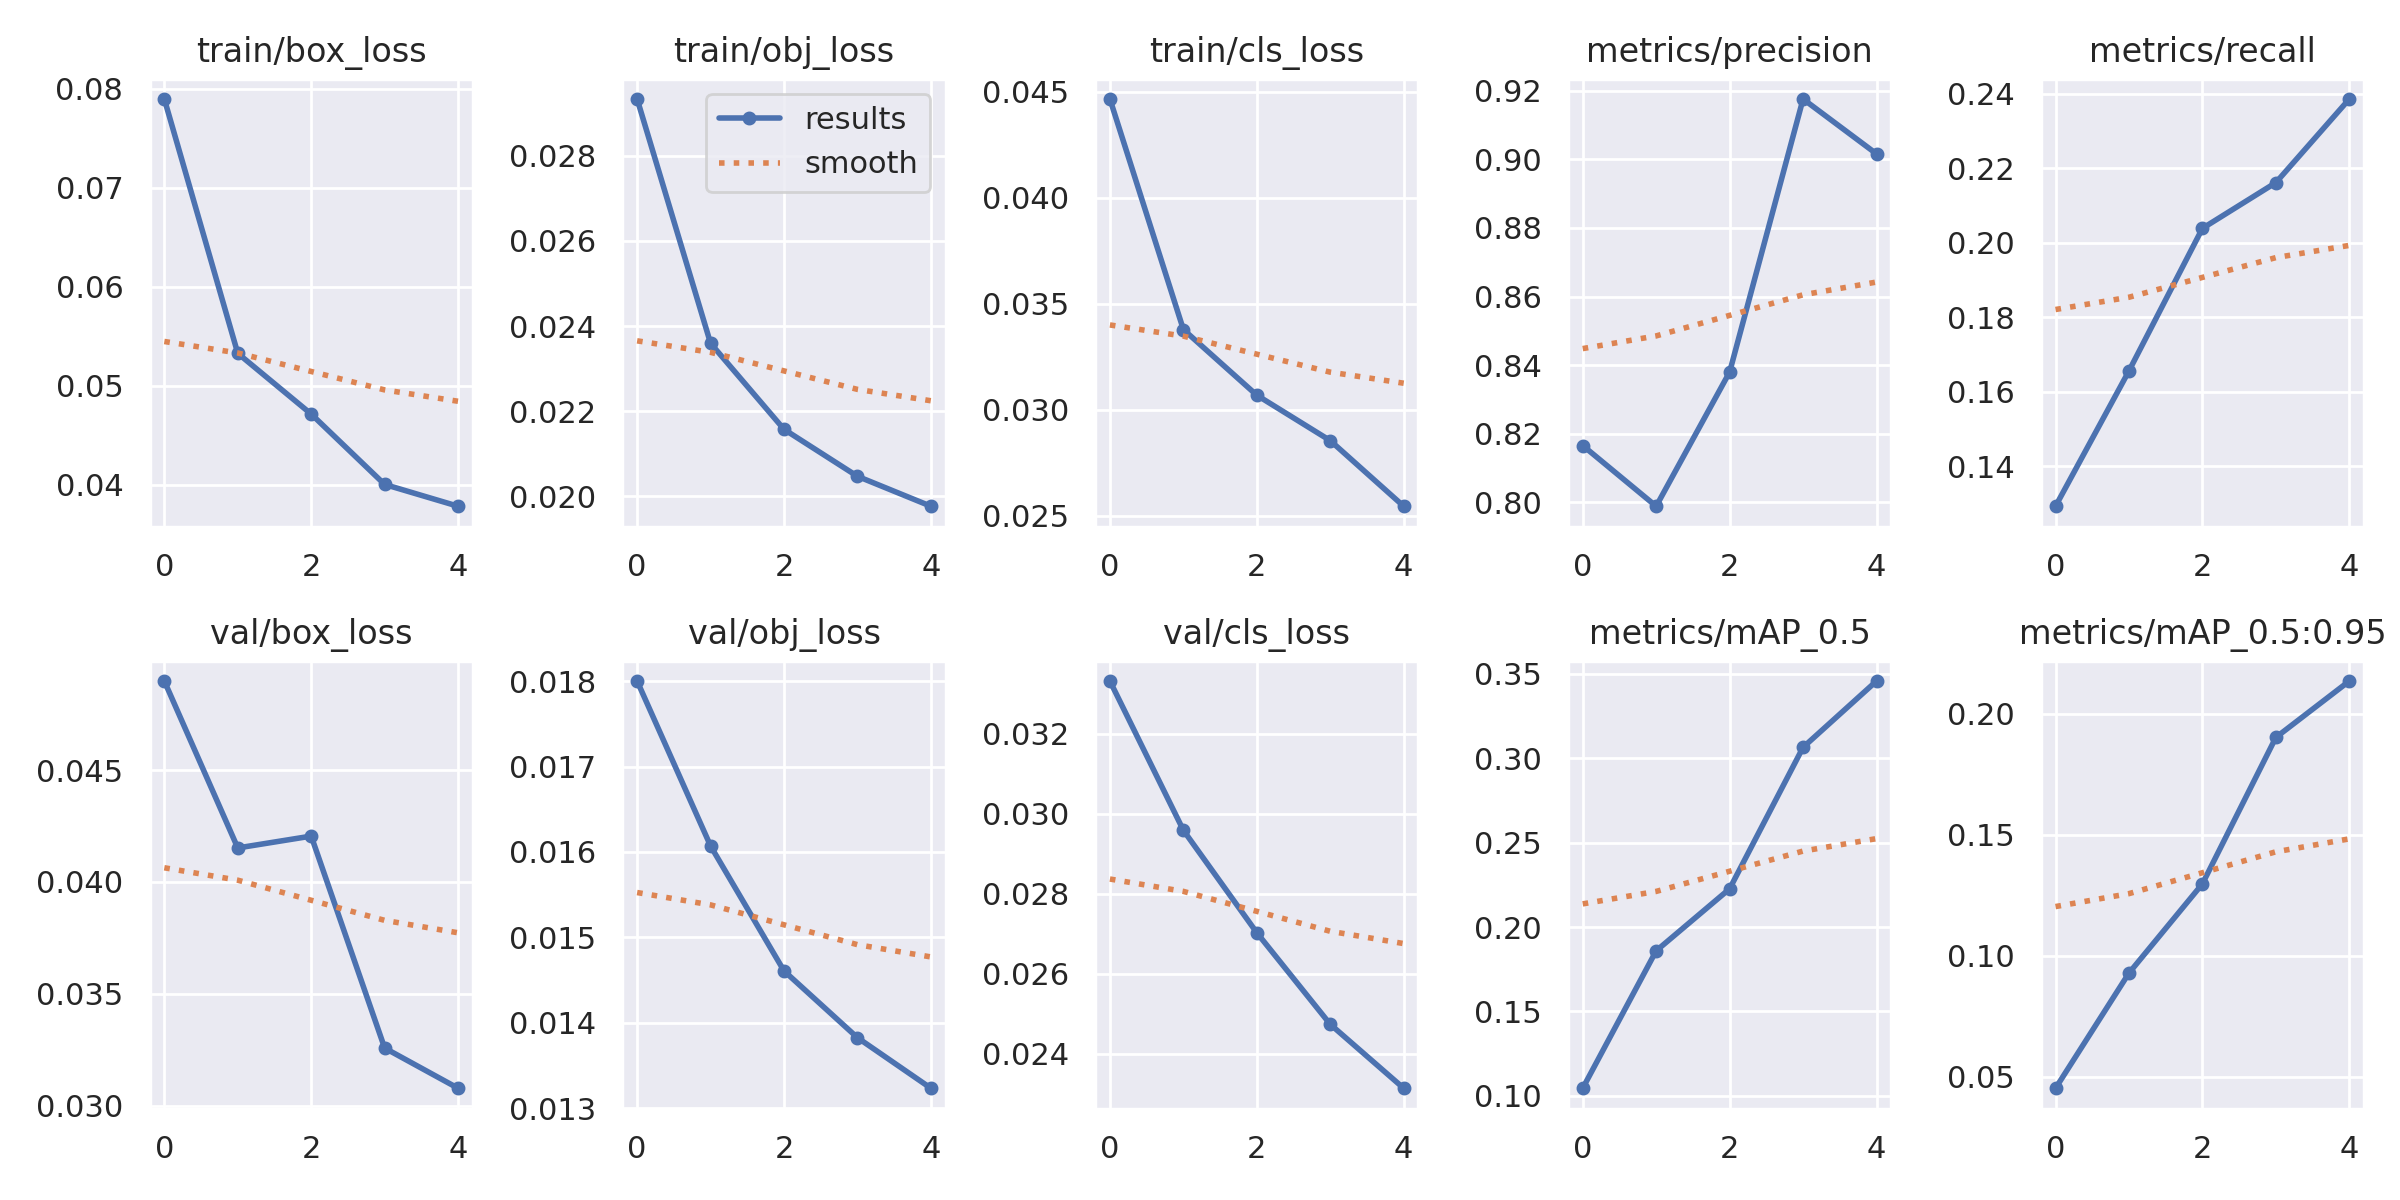

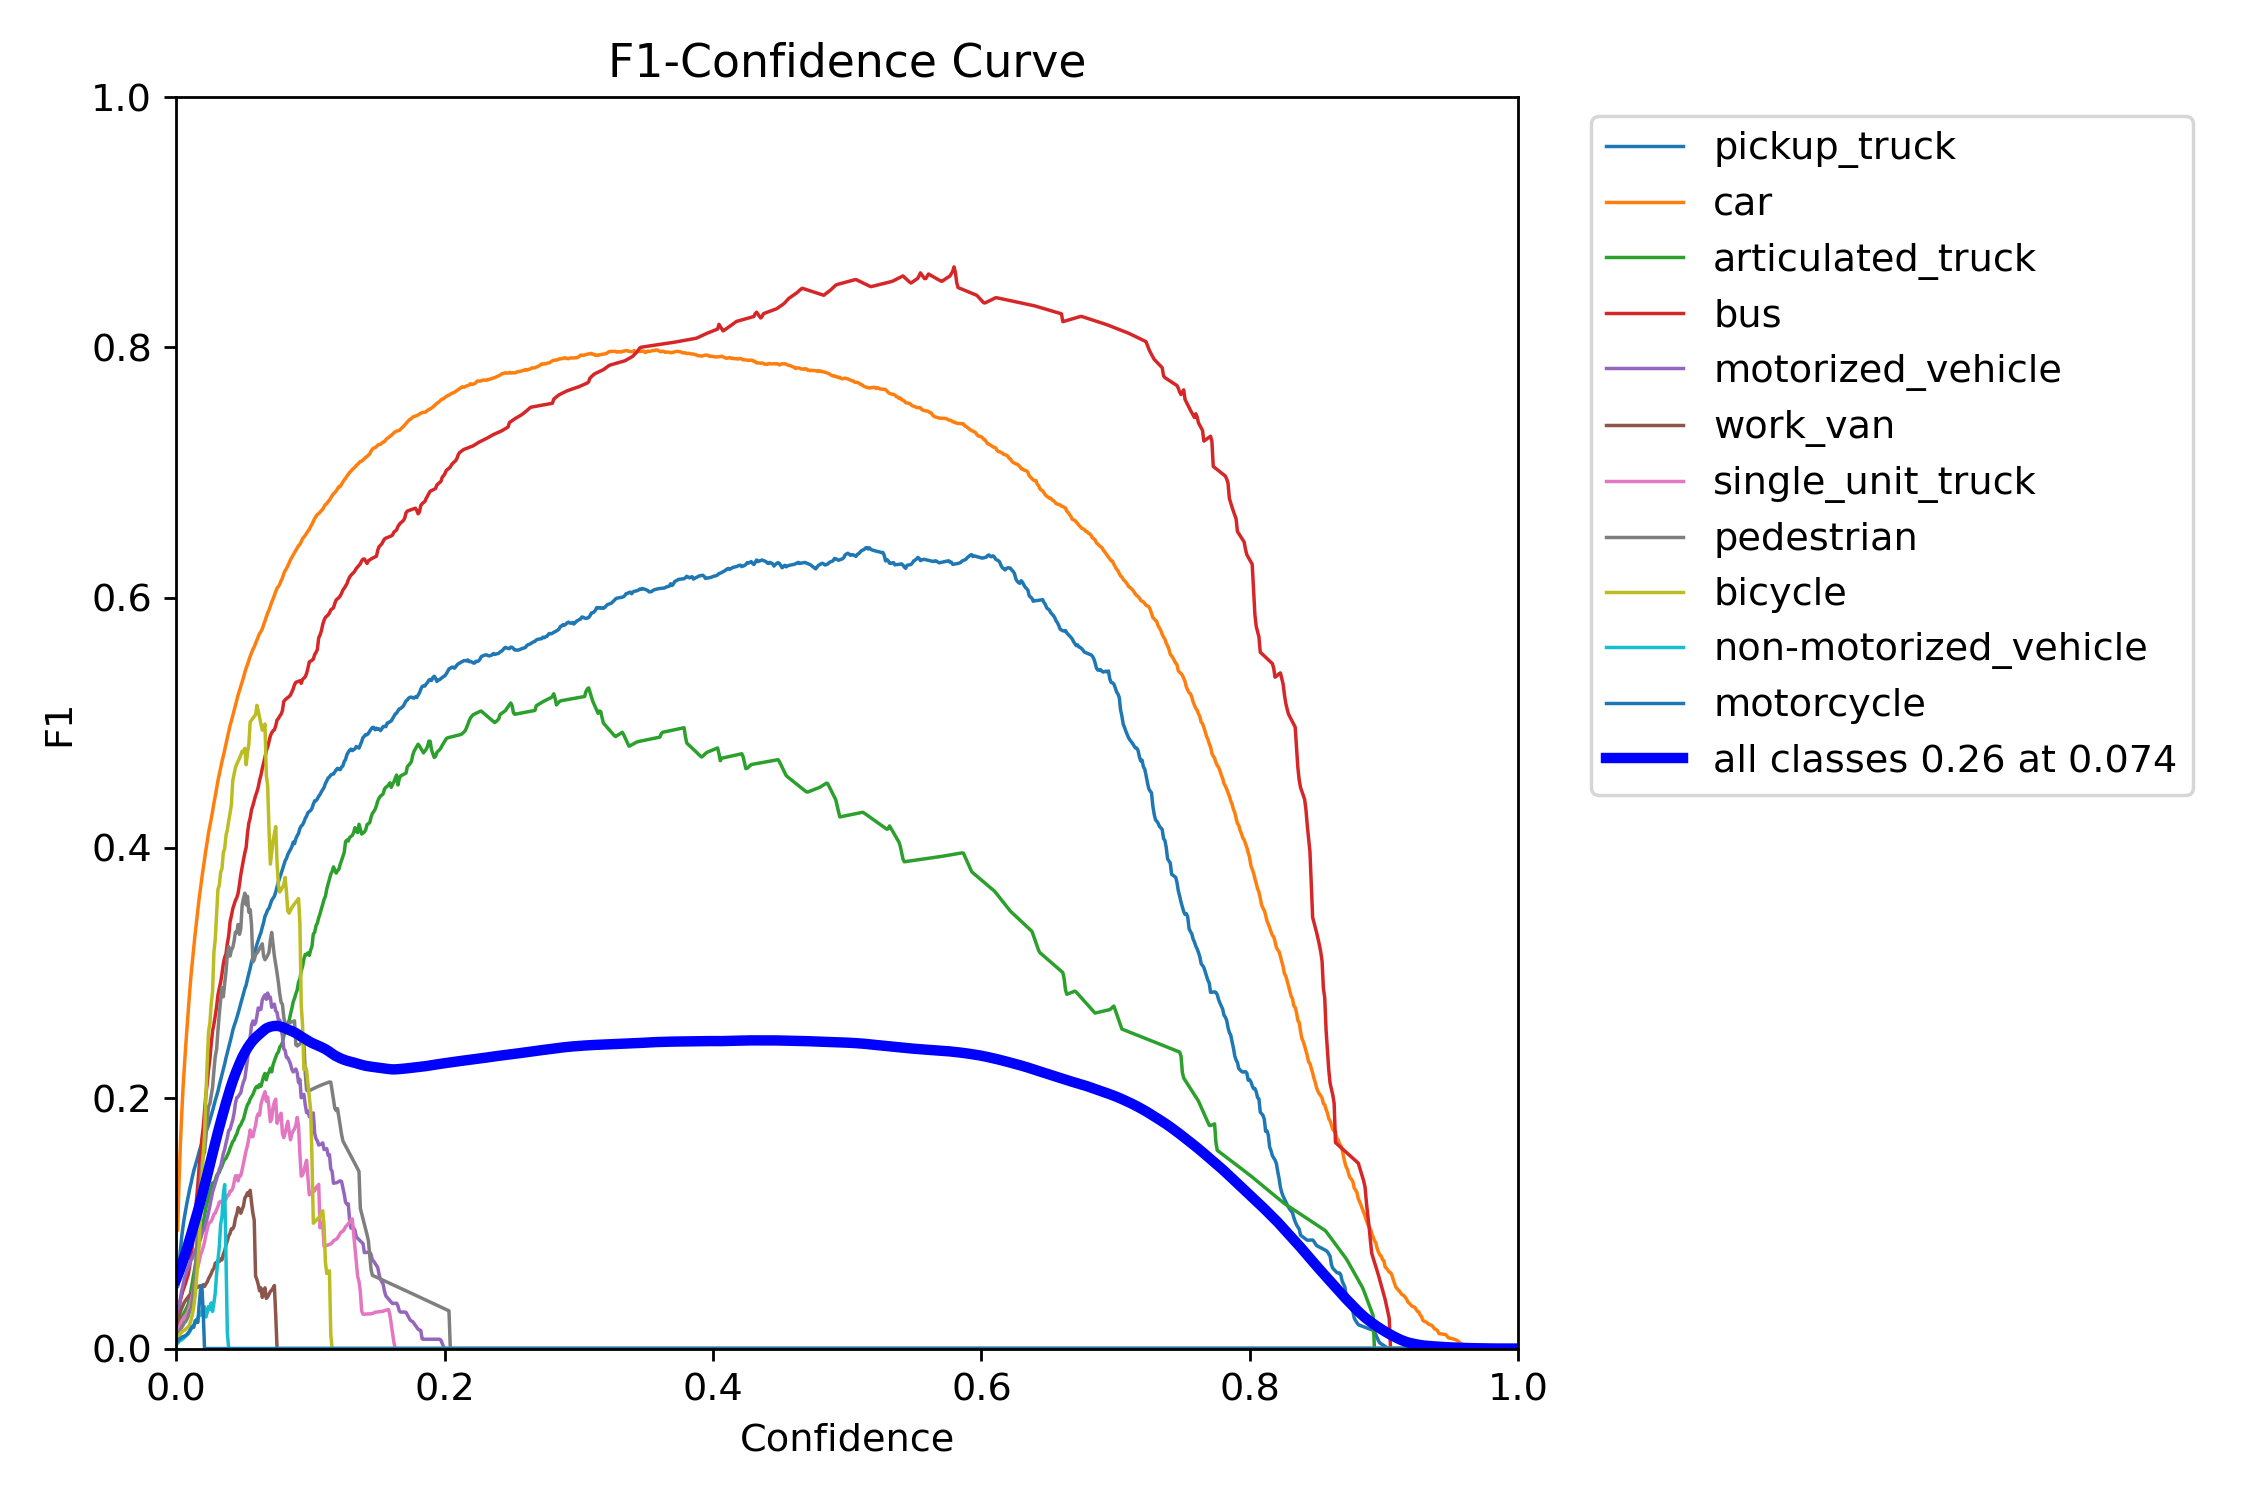

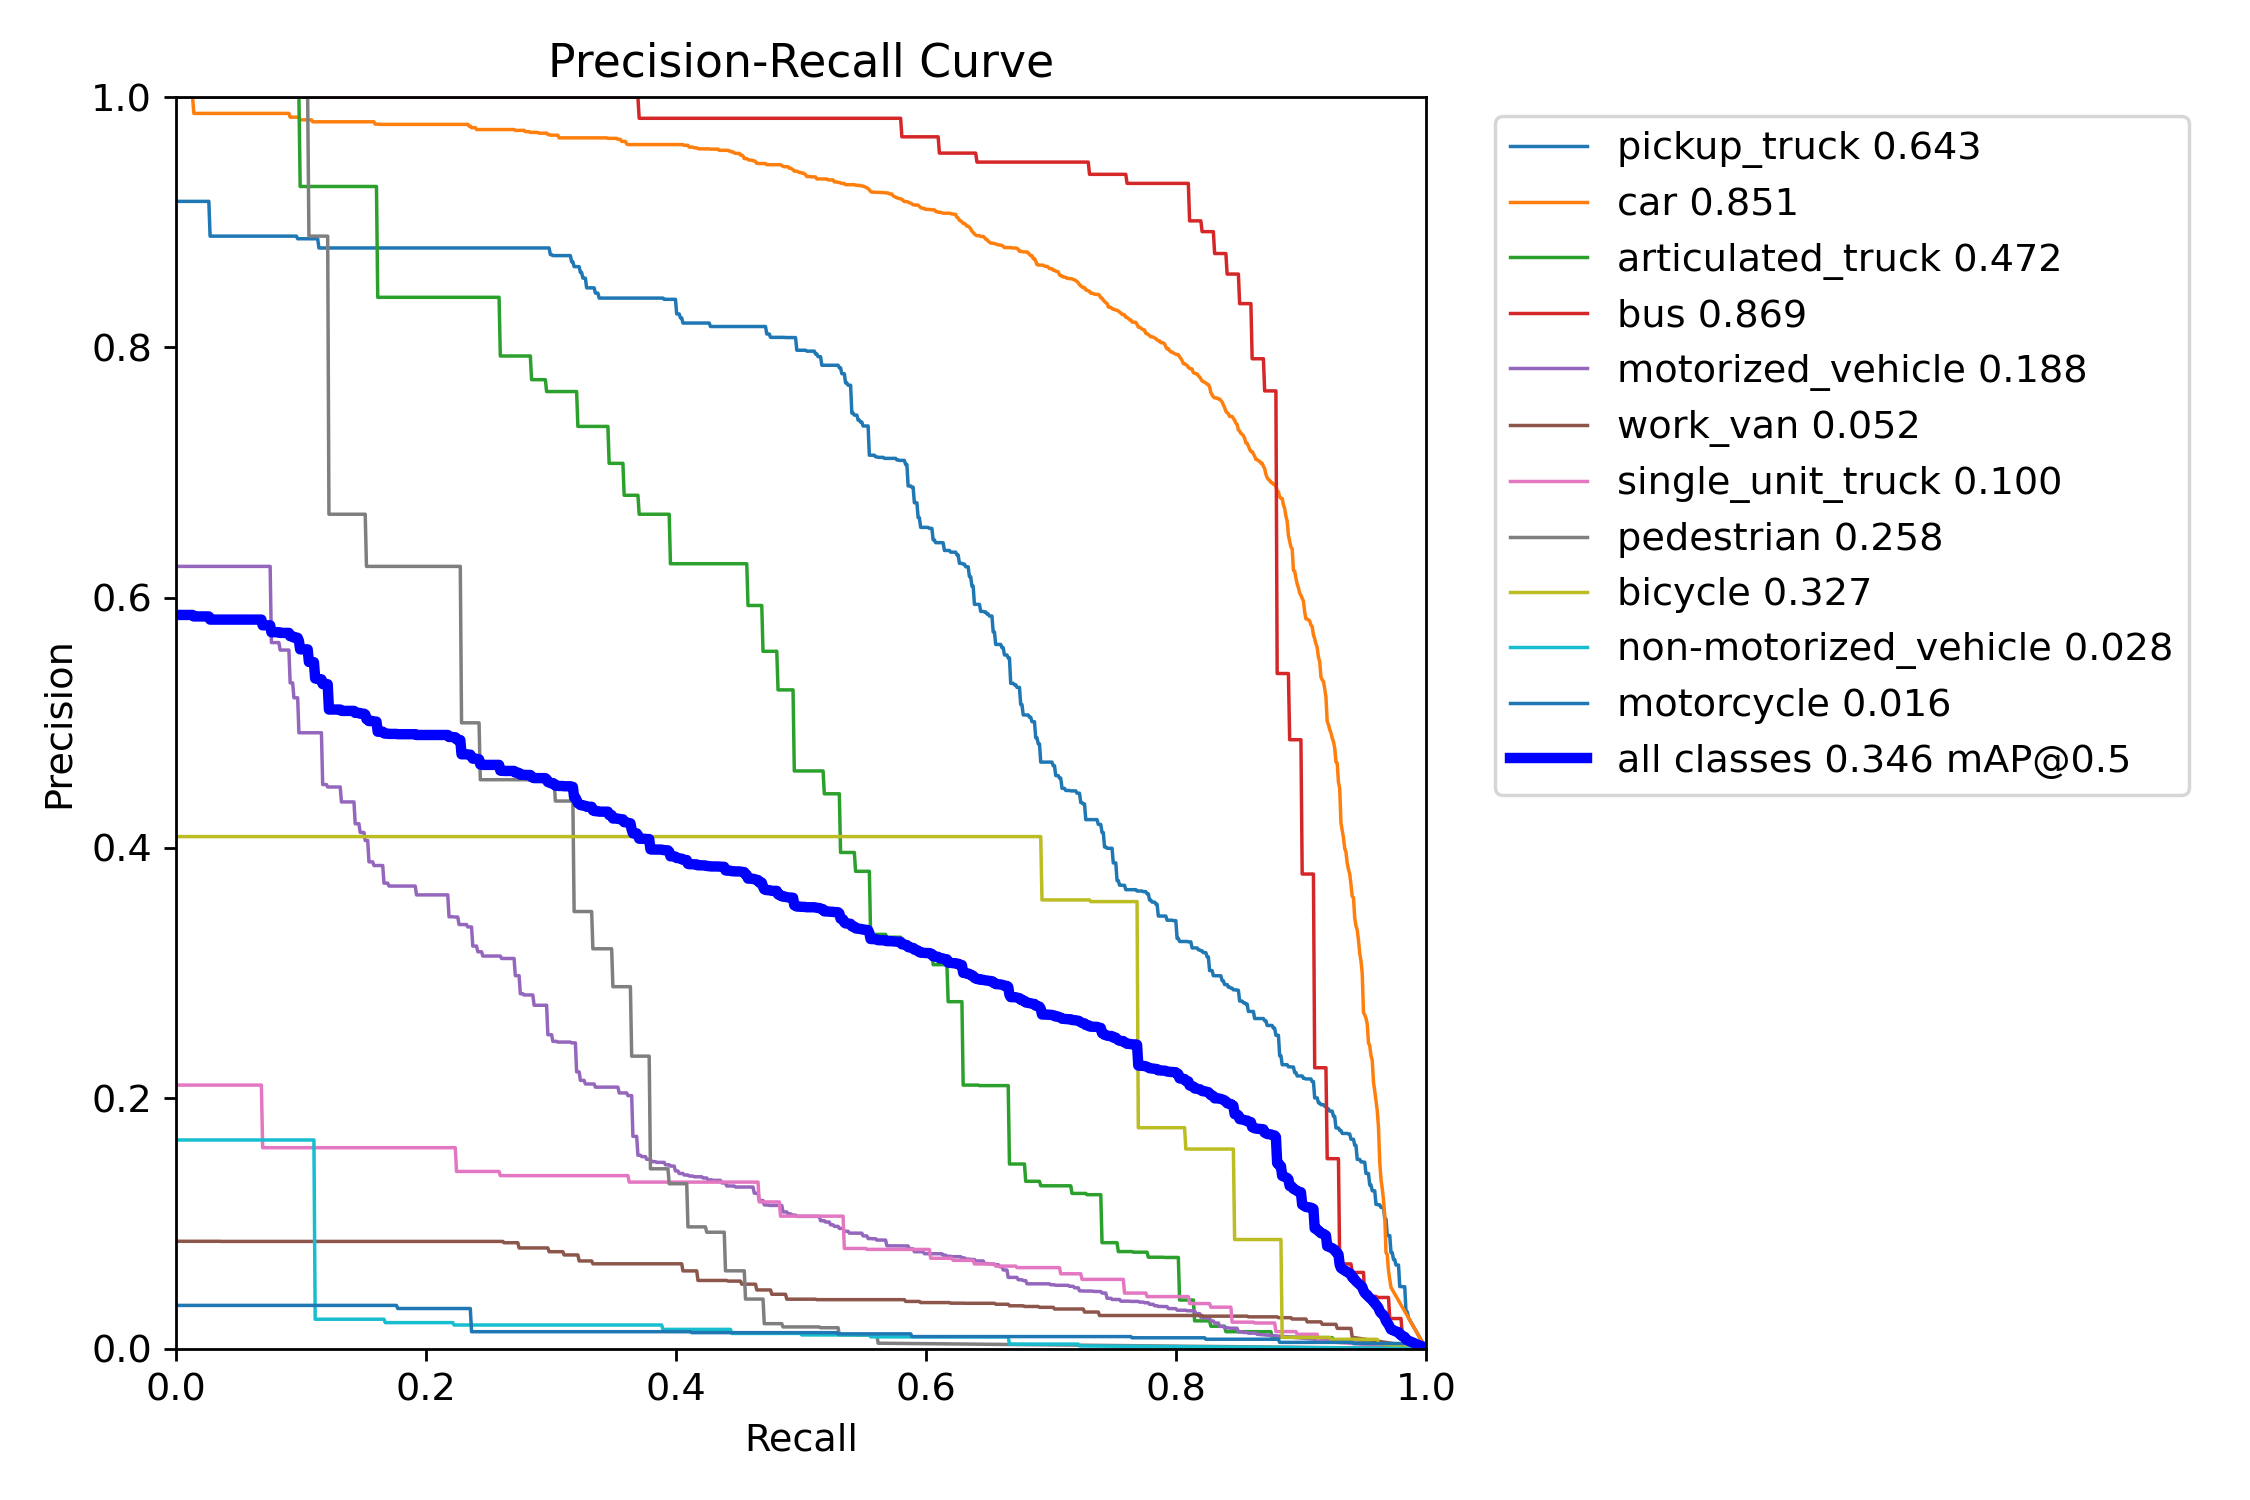

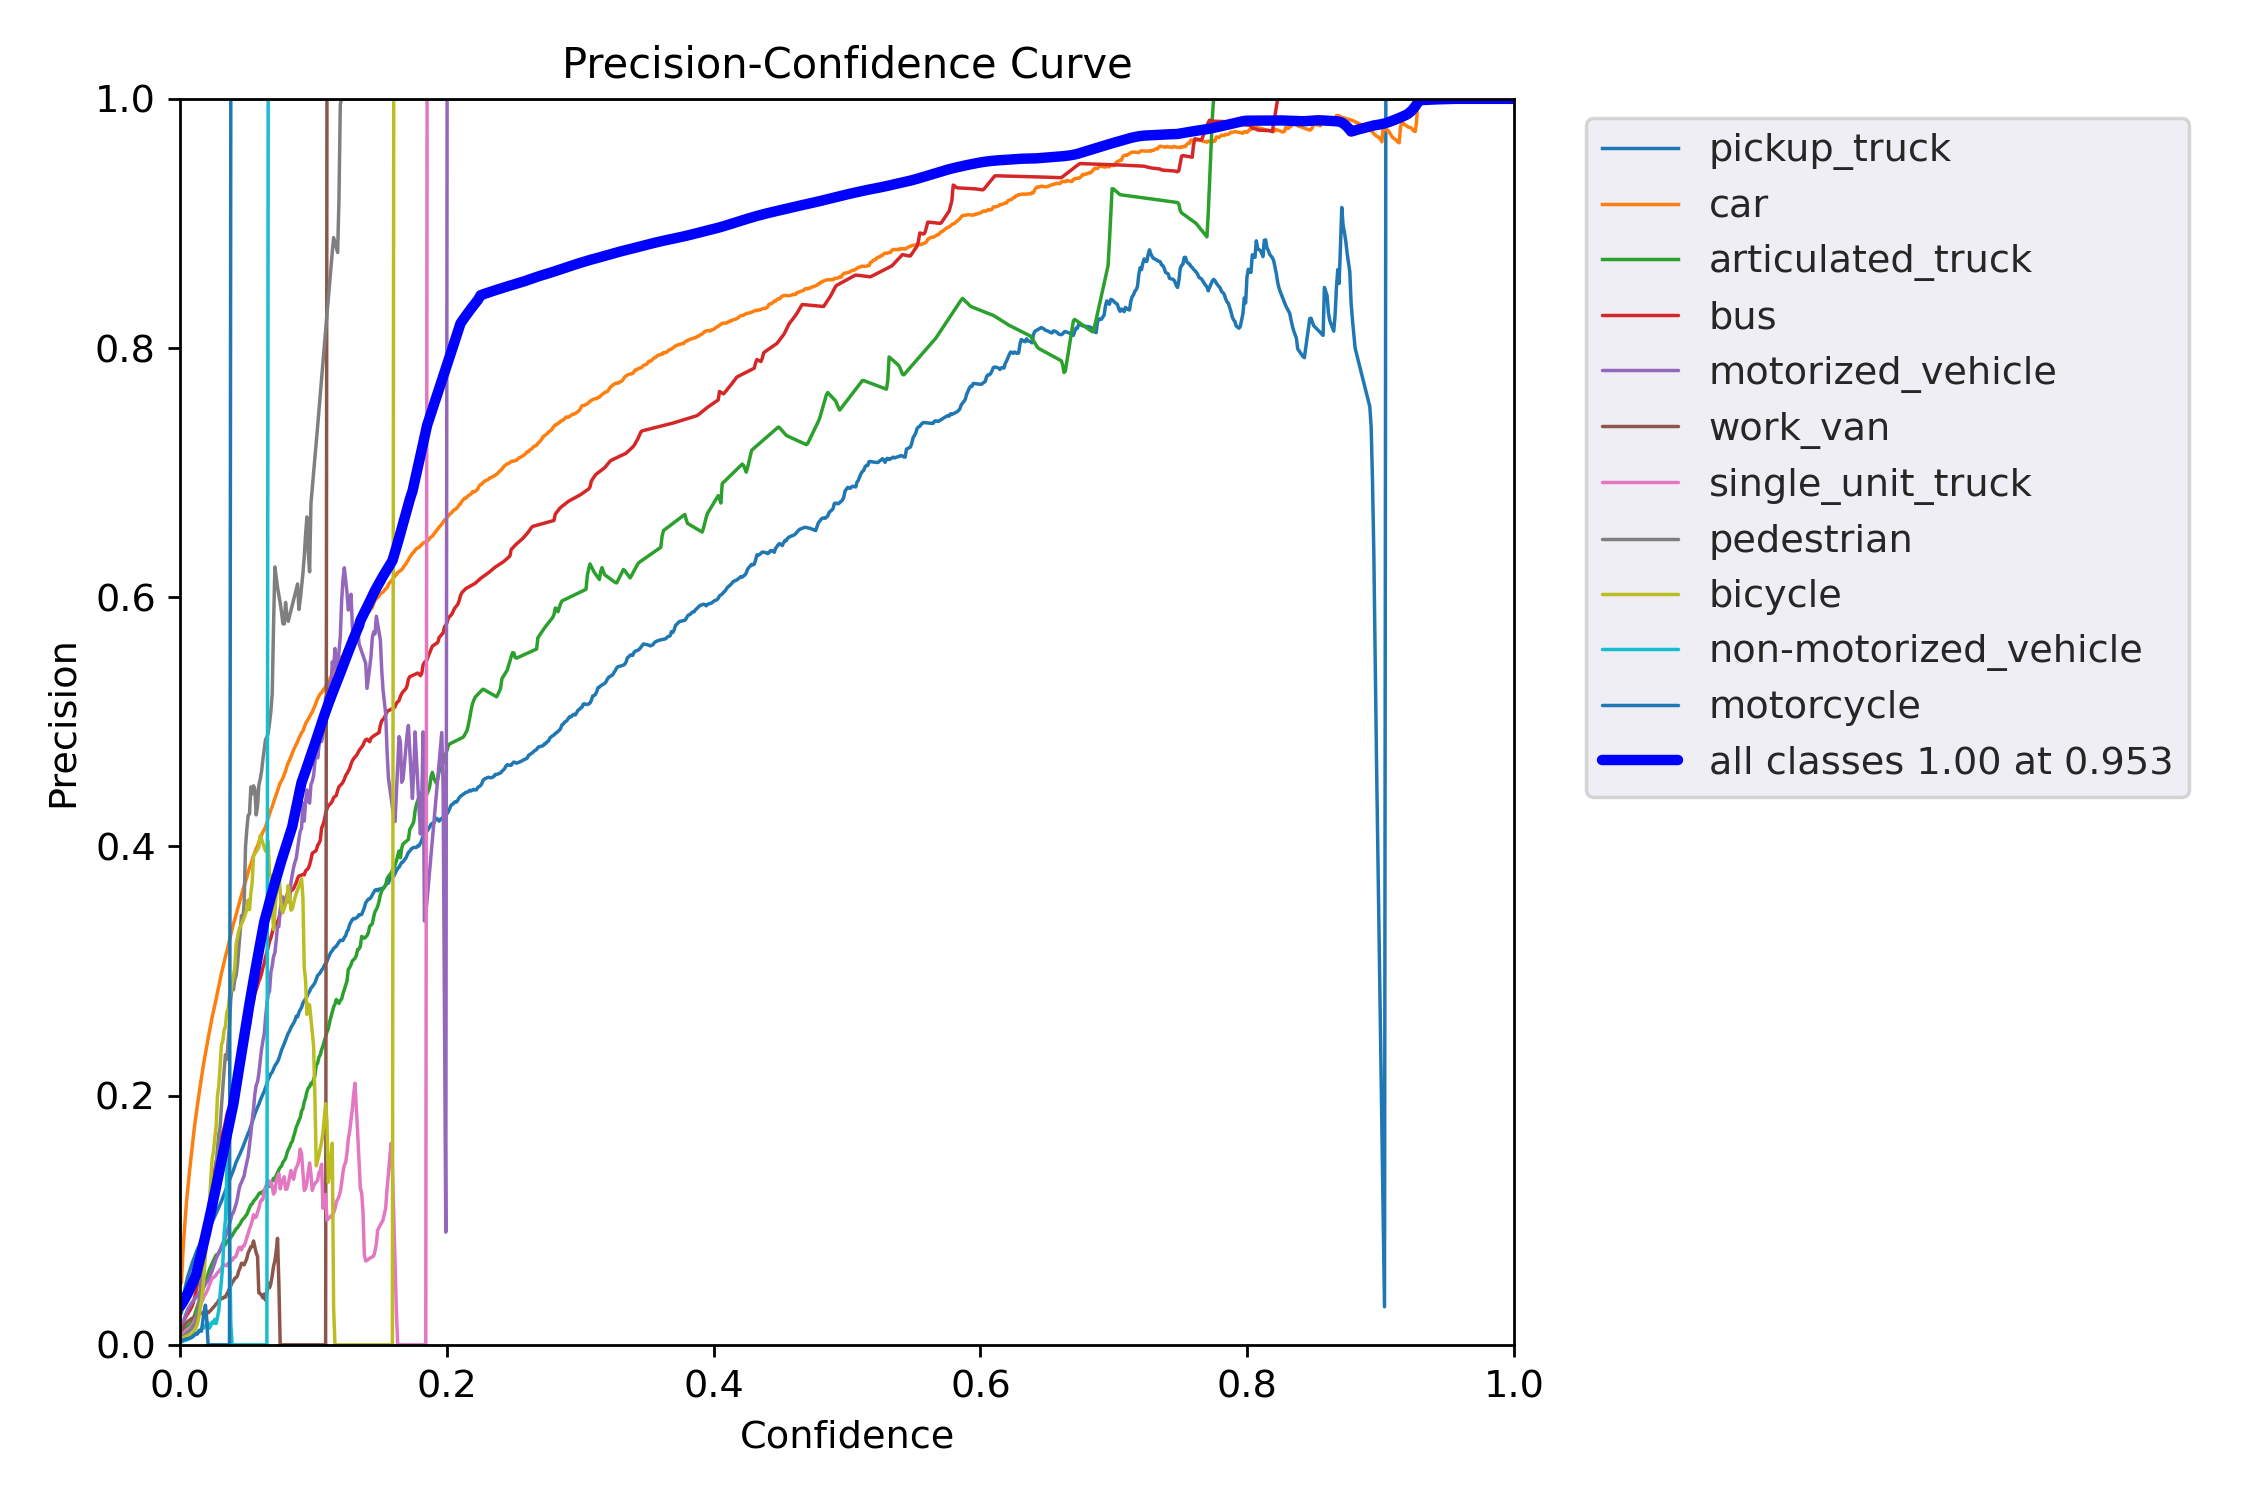

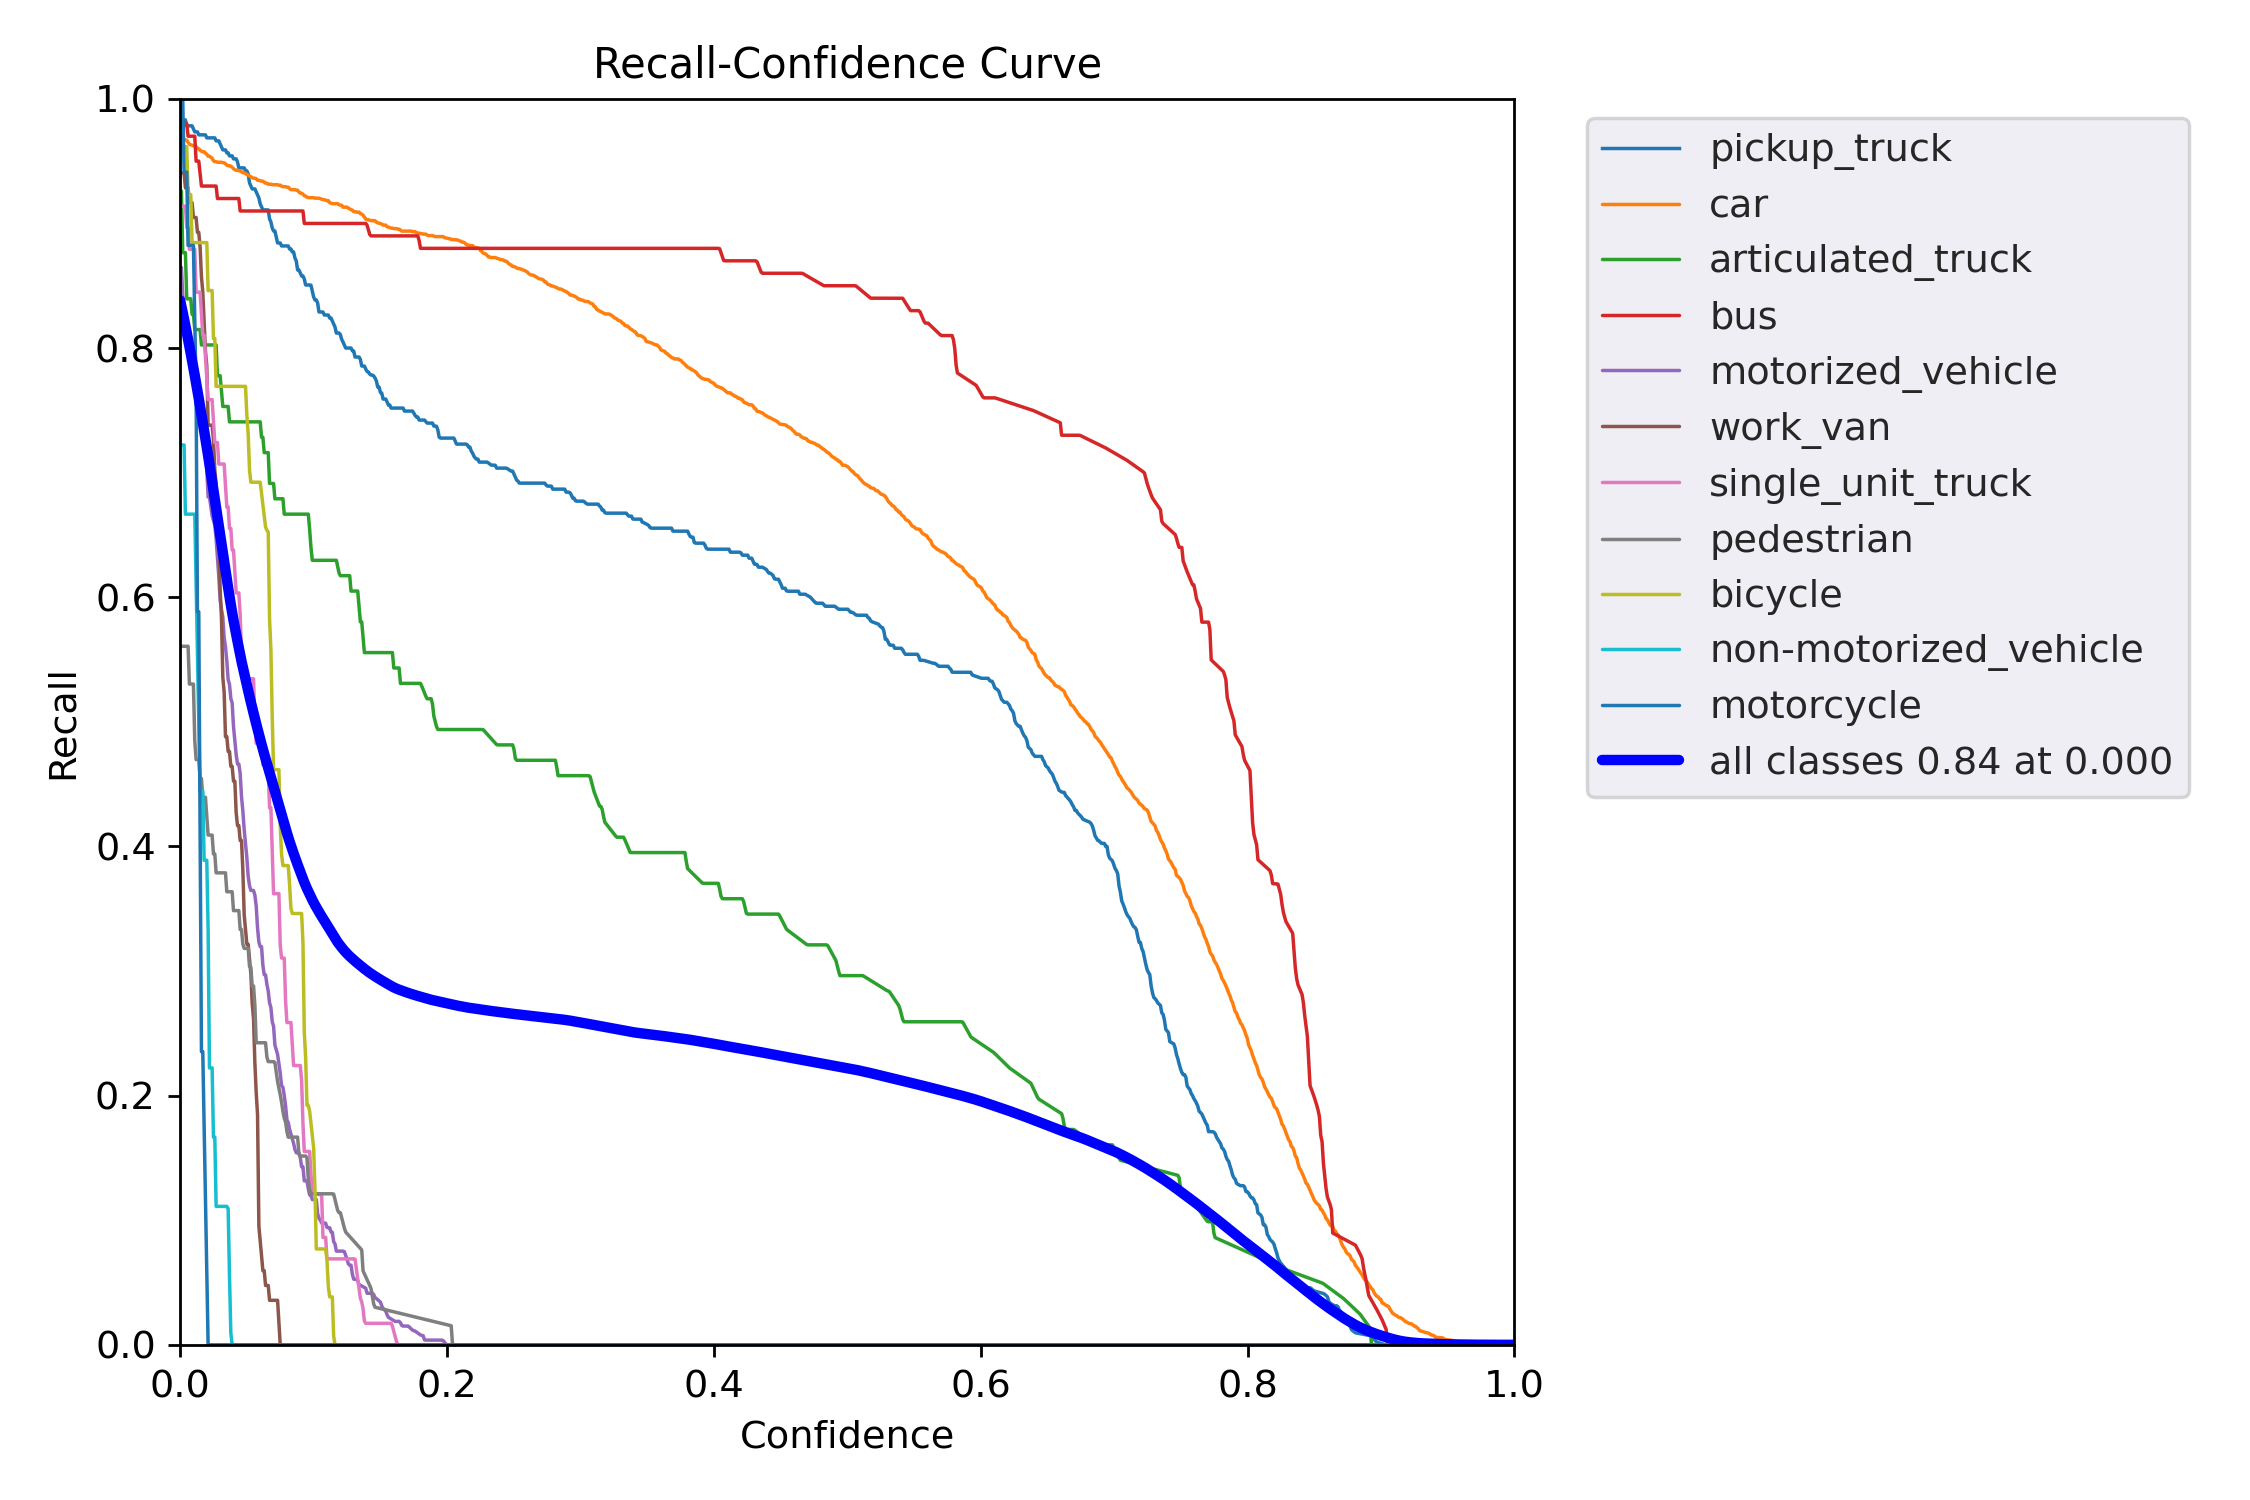

In [2]:
# Path to results
results_dir = '/content/drive/MyDrive/Colab Notebooks/capstone1/yolov5/output/exp9/'  # Adjust this path as needed

# Display the main training results plot
display(Image(filename=os.path.join(results_dir, 'results.png')))

# Display individual plots
display(Image(filename=os.path.join(results_dir, 'F1_curve.png')))
display(Image(filename=os.path.join(results_dir, 'PR_curve.png')))
display(Image(filename=os.path.join(results_dir, 'P_curve.png')))
display(Image(filename=os.path.join(results_dir, 'R_curve.png')))

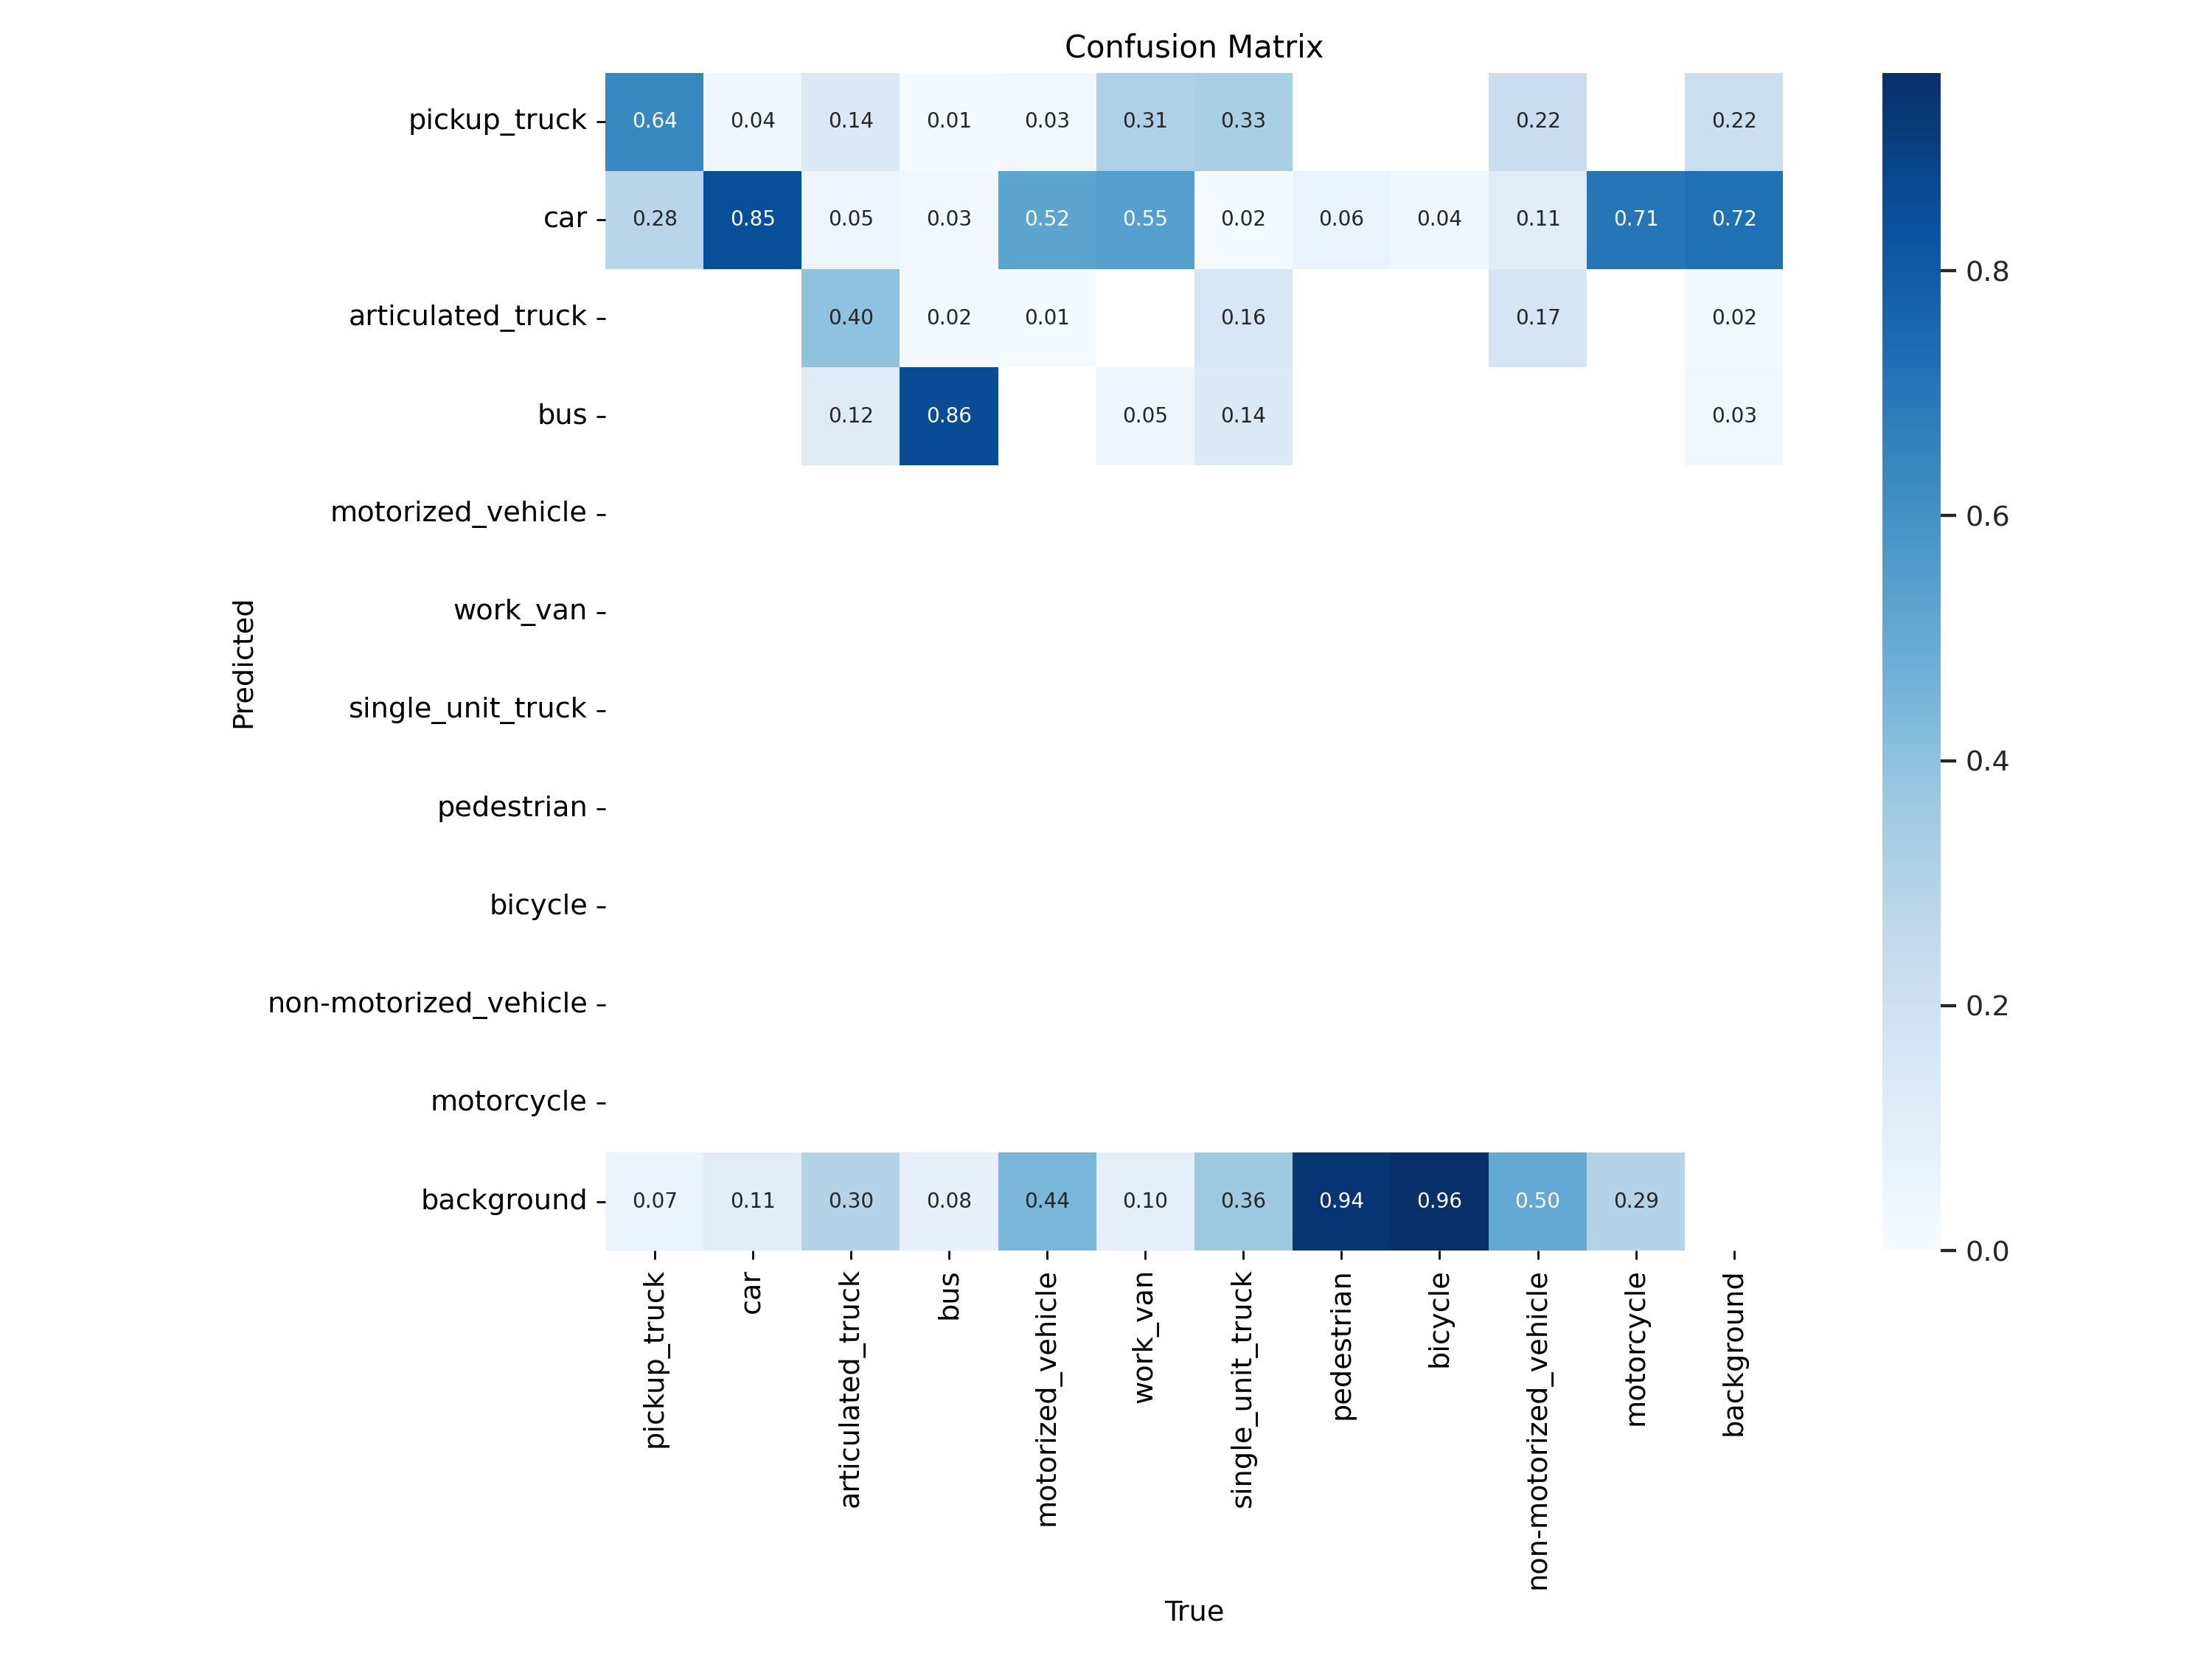

In [3]:
# Display confusion matrix
display(Image(filename=os.path.join(results_dir, 'confusion_matrix.png')))

### Step 6: Show validation predictions

In [16]:
# Display validation predictions

for i in range(3):
  print(f"Validation Batch {i}: True labels.jpg")
  display(Image(filename=os.path.join(results_dir, f'val_batch{i}_labels.jpg')))
  print(f"Validation Batch {i}: Predictions.jpg")
  display(Image(filename=os.path.join(results_dir, f'val_batch{i}_pred.jpg')))

Output hidden; open in https://colab.research.google.com to view.

### Step 7: Visualize inference images

In [20]:
!python '/content/drive/MyDrive/Colab Notebooks/capstone1/yolov5/detect.py' \
  --weights '/content/drive/MyDrive/Colab Notebooks/capstone1/yolov5/output/exp9/weights/best.pt' \
  --img 416 --conf 0.25 \
  --source "/content/drive/MyDrive/Colab Notebooks/capstone1/test_images" \
  --project '/content/drive/MyDrive/Colab Notebooks/capstone1/yolov5/inference_results' \
  --name 'run1' --save-txt --save-conf


detect: weights=['/content/drive/MyDrive/Colab Notebooks/capstone1/yolov5/output/exp9/weights/best.pt'], source=/content/drive/MyDrive/Colab Notebooks/capstone1/test_images, data=drive/MyDrive/Colab Notebooks/capstone1/yolov5/data/coco128.yaml, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/drive/MyDrive/Colab Notebooks/capstone1/yolov5/inference_results, name=run1, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
fatal: cannot change to '/content/drive/MyDrive/Colab': Not a directory
YOLOv5 🚀 2024-7-8 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7039792 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/driv

In [21]:
display(Image(filename=
  '/content/drive/MyDrive/Colab Notebooks/capstone1/yolov5/inference_results/run1/img1.jpg'))

Output hidden; open in https://colab.research.google.com to view.